In [1]:
import dolfin as df                                                    
import numpy as np                                                      
import os                                                               
import time as time_module 
import matplotlib.pyplot as plt
import csv                                                              
import yaml #version higher than 5.0

df.parameters['ghost_mode']= 'shared_facet' #for parallel program          
#My library      
from modules.SystemMatrix import SystemMatrix # <--System Matrix class
from modules.Mesh import H5Mesh  # <-- Mesh class
from modules.FunctionSpace  import FunctionSpace #<--Function Space Class
from modules.FormulateVariationalProblem import FormulateVariationalProblem
from modules.Solver import Solver

#Inputs                                  
with open(r'input_r13_ring_nosource_rot_inflow.yml') as input_file:
    my_input_cls = yaml.load(input_file, Loader=yaml.FullLoader)

projection = False
manual = True
automatic = False

my_current_mesh = my_input_cls['mesh_list'][0] 
#step-1 : Convert current_mesh_name into a char_list    
#step-2: Select the 4th-to-last element in the char_list 
#Step-3: Convert the 4th-to-last element to integer     
#Now I can run any single mesh I want in whichever order
mesh_number=0  #For saving files according to mesh number
mesh_number = int(list(my_current_mesh)[-4])  
print(mesh_number)

1


Maximum value of the mesh:  0.6340332990696501


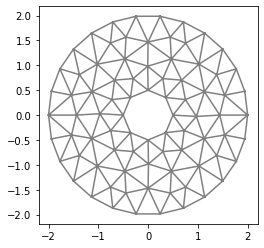

In [2]:
#MESH
my_mesh_cls = H5Mesh(my_current_mesh) #<-- Class instance is created
#print(my_current_mesh)  
print("Maximum value of the mesh: ", my_mesh_cls.mesh.hmax()) 
df.plot(my_mesh_cls.mesh)

In [3]:
#FUNCTION SPACE
problem_type = my_input_cls['problem_type']
number_of_moments = my_input_cls['number_of_moments']
my_function_space_cls = FunctionSpace(my_input_cls, my_mesh_cls) #<-- class instance
my_function_space_cls.set_function_space()

In [4]:
#SYSTEM MATRIX
my_system_matrix_cls = SystemMatrix(my_input_cls, my_mesh_cls) # <-- class instance
my_system_matrix_cls.convert_to_ufl_form()

In [5]:
#my_system_matrix_cls.SP_Coeff

In [6]:
#my_system_matrix_cls.SA_x
#np.savetxt("SAx_old.txt", my_system_matrix_cls.SA_x, fmt="%d")
#np.savetxt("SAy_old.txt", my_system_matrix_cls.SA_y, fmt="%d")
#np.savetxt("SP_Coeff_old.txt", my_system_matrix_cls.SP_Coeff, fmt="%d")
#np.savetxt("BC1_old.txt", my_system_matrix_cls.BC1, fmt="%s")
#np.savetxt("BC2_old.txt", my_system_matrix_cls.BC2, fmt="%s")
#np.savetxt("BC1_rhs_old.txt", my_system_matrix_cls.BC1_rhs, fmt="%s")
#np.savetxt("BC2_rhs_old.txt", my_system_matrix_cls.BC2_rhs, fmt="%s")

In [7]:
#VARIATIONAL PROBLEM
my_var_prob_cls = FormulateVariationalProblem(
    my_input_cls,
    my_mesh_cls, 
    my_system_matrix_cls, 
    my_function_space_cls
    ) #<-- class instance
my_var_prob_cls.create_lhs()
my_var_prob_cls.create_rhs()

In [8]:
#SOLVER
my_solver_cls = Solver(my_input_cls, my_function_space_cls, my_var_prob_cls) #<-- class instance
if problem_type == 'nonlinear':
    my_solver_cls.custom_newton_solver()
    u = my_solver_cls.u
else:
    my_solver_cls.inbuilt_linear_solver()
    u = my_solver_cls.u_Function

In [9]:
#===============                                                        
#Post-processing                                                        
#=============== 
sol = u.split()

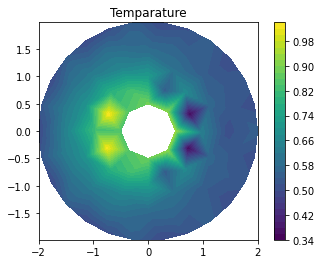

In [10]:
c =df.plot(sol[3])
plt.colorbar(c)
plt.title('Temparature')
plt.savefig('edge.png', bbox_inches='tight')

In [11]:
def write_func(field_name, variable_name, mesh_num):                
    xdmffile_u = df.XDMFFile(df.MPI.comm_world,                                   
                          'results_mathematica/{0}_{1}.xdmf'                                                  
                          .format(variable_name,mesh_num))                                
    xdmffile_u.write(field_name)                                        
    xdmffile_u.close()                                                      
for i in range(my_input_cls["number_of_moments"]):                                                    
    write_func(sol[i], i, mesh_number)  

In [12]:
#file = File("sol.pvd")
#file << u.split()[0]
#file << u.split()[1]
#file << u.split()[2]
'''
file = df.File("sol0.pvd")
file.write(sol[0])
file1 = df.File("sol1.pvd")
file1.write(sol[1])
file2 = df.File("sol2.pvd")
file2.write(sol[2])
'''

'\nfile = df.File("sol0.pvd")\nfile.write(sol[0])\nfile1 = df.File("sol1.pvd")\nfile1.write(sol[1])\nfile2 = df.File("sol2.pvd")\nfile2.write(sol[2])\n'

In [13]:
xmesh = my_function_space_cls.V.tabulate_dof_coordinates()[:,0]
ymesh = my_function_space_cls.V.tabulate_dof_coordinates()[:,1]
ux =sol[1].vector().get_local()
uy =sol[2].vector().get_local()

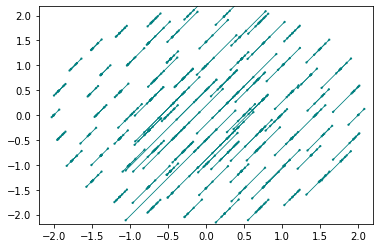

In [14]:
plt.quiver(xmesh,ymesh,ux,uy, color='Teal', headlength=1)

In [15]:

#X_, Y_ = np.meshgrid(xmesh,ymesh)
'''
#Z = []
for i in range(len(xmesh)):
    new =[]
    for i in range(len(xmesh)):
        new.append([sol[1].vector().get_local()[i], sol[2].vector().get_local()[j]])
    Z.append(new)
Z = np.array(Z)
'''

'\n#Z = []\nfor i in range(len(xmesh)):\n    new =[]\n    for i in range(len(xmesh)):\n        new.append([sol[1].vector().get_local()[i], sol[2].vector().get_local()[j]])\n    Z.append(new)\nZ = np.array(Z)\n'

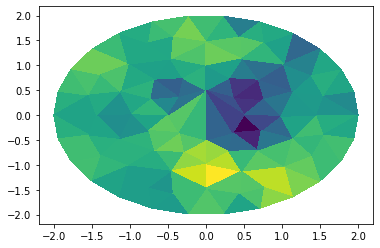

In [16]:
plt.tripcolor(xmesh,ymesh,ux)
#plt.tricontour(xmesh,ymesh,uy)

In [17]:
if automatic: 
    u_old = u
u_old.split()[3].compute_vertex_values()-u.split()[3].compute_vertex_values()

NameError: name 'u_old' is not defined